In [1]:
from torch import nn
import matplotlib.pyplot as plt
from torchsummary import summary

import lightdde as dde
from essential import *
from qmodels import *

# Inference

In [2]:
data = dde.data.PDEData(
    domain=domain,
    pde=pde,
    bcs=[boundary_condition_u, boundary_condition_v, boundary_condition_right_p],
    exact_solution=[u_func, v_func, p_func],
    num_domain=2601,
    num_bc=400,
    num_test=5000,
)

# Models (pick one!)

## classic model

In [3]:
net = ClassicNet2(in_dim=2, out_dim=3, hidden_dim=12, activation=nn.SiLU)

model = dde.Model(
    data=data,
    model=net,
    save_path="models/classic2_1000e_12h_silu/",
    log_every=10,
    save_every=100,
)

model.compile()

Loaded snapshot at epoch 1000


## FNN model

In [32]:
net = FNN()

model = dde.Model(
    data=data,
    model=net,
    save_path="models/FNN_1000e_tanh/",
    log_every=100,
    save_every=100,
)

model.compile()

Loaded snapshot at epoch 1000


## quantum model

In [10]:
net = QuantumNet(in_dim=2, out_dim=3, activation=nn.SiLU)

model = dde.Model(
    data=data,
    model=net,
    save_path="models/quantum_2000e_silu/",
    log_every=20,
    save_every=10,
)

model.compile()

Loaded snapshot at epoch 2000


In [4]:
summary(net, input_size=(1, 2), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 12]              36
              SiLU-2                   [-1, 12]               0
            Linear-3                   [-1, 12]             156
              SiLU-4                   [-1, 12]               0
            Linear-5                    [-1, 1]              13
           CScalar-6                    [-1, 1]               0
            Linear-7                   [-1, 12]              36
              SiLU-8                   [-1, 12]               0
            Linear-9                   [-1, 12]             156
             SiLU-10                   [-1, 12]               0
           Linear-11                    [-1, 1]              13
          CScalar-12                    [-1, 1]               0
           Linear-13                    [-1, 1]               3
           Linear-14                   

# Plotting

Executed in 0.02 sec.


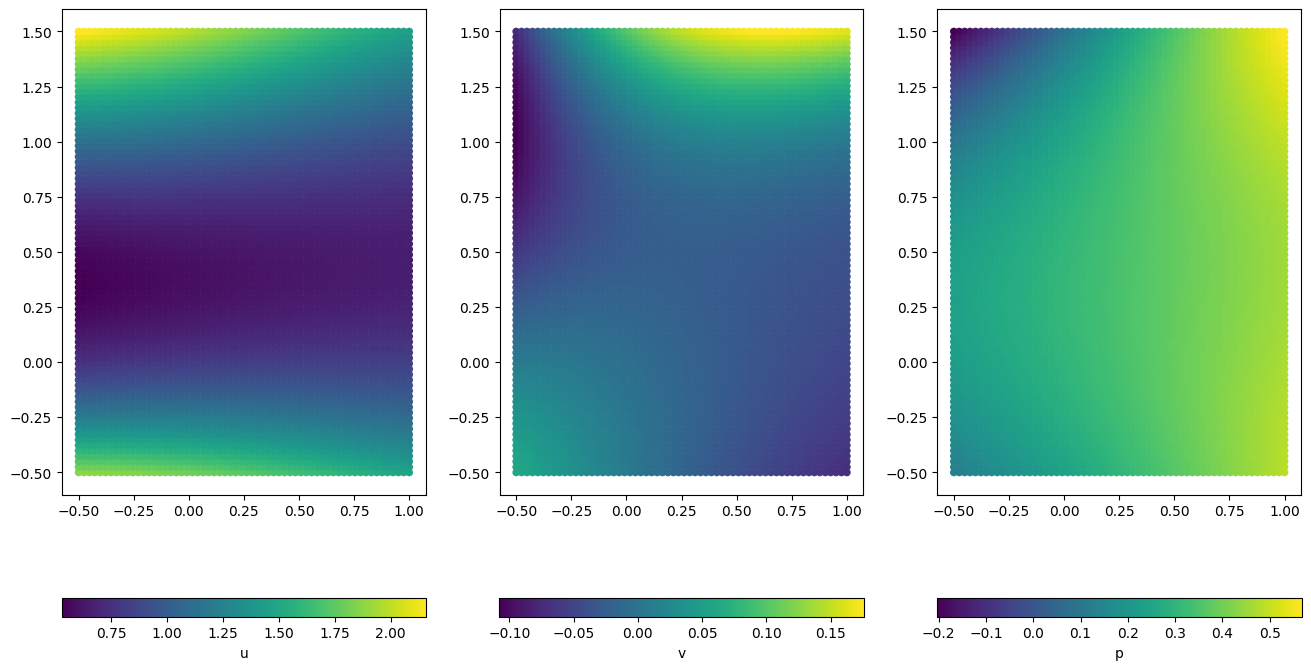

''

In [5]:
dde.scatter_plot(model, s=20)
;

# Load csv loss

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
df_c_silu = pd.read_csv("models/classic_1000e_20h_silu/log.csv")
df_q_silu = pd.read_csv("models/quantum_2000e_silu/log.csv", index_col="epoch")
# df_q_relu = pd.read_csv("models/quantum_2000e_relu/log.csv", index_col="epoch")

In [15]:
df_q_silu.tail()

,loss_train,u_err,v_err,p_err
epoch,,,,
1920,0.244291,0.623615,0.146672,0.437886
1940,0.244127,0.623291,0.146723,0.437608
1960,0.243962,0.622962,0.146775,0.437326
1980,0.243797,0.622628,0.146826,0.437040
2000,0.243633,0.622289,0.146878,0.436751


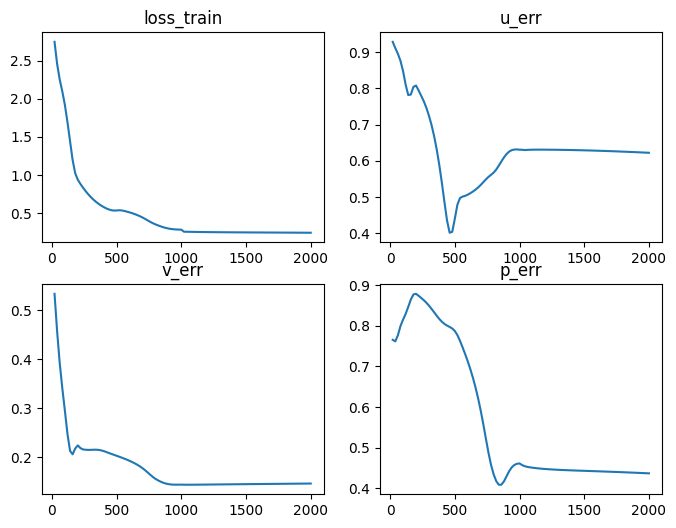

In [16]:
errs = ["loss_train", "u_err", "v_err", "p_err"]

plt.figure(figsize=(8, 6))
for i, err in enumerate(errs):
    plt.subplot(2, 2, i+1)
    plt.plot(df_q_silu[err])
    plt.title(err)
plt.show()